In [1]:
%set_env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:

import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from alibi.explainers.similarity.grad import GradientSimilarity

In [3]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y].astype('float32')

class TorchDataset(torch.utils.data.Dataset):
    """Utility class to create a torch dataloader from numpy arrays.
    """
    def __init__(self, *indexables):
        self.indexables = indexables

    def __getitem__(self, idx):
        output = tuple(indexable[idx] for indexable in self.indexables)
        return output if len(output) > 1 else output[0]

    def __len__(self):
        return len(self.indexables[0])
    
def eval_model(model, loader, verbose=1):
    model.eval()
    logits, labels = [], []
    with torch.no_grad():
        if verbose == 1:
            loader = tqdm(loader)
        for x, y in loader:
            y_hat = model(x)
            logits += [y_hat.cpu().numpy()]
            labels += [y.cpu().numpy()]
    logits = np.concatenate(logits, 0)
    preds = np.argmax(logits, 1)
    labels = np.concatenate(labels, 0)
    print(preds, labels)
    if verbose == 1:
        accuracy = (preds == labels.argmax()).mean()
        print(f'Accuracy: {accuracy:.3f}')
    return logits, preds

## Load data

Loading and preparing the 20 news group data set.

In [4]:
data = fetch_20newsgroups(shuffle=True, random_state=1, subset='all',
                          remove=('headers', 'footers', 'quotes'),
                          return_X_y=False)
X, y = np.asarray(data.data), data.target
target_names = data.target_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#y_train, y_test = y_train.astype('float32'), y_test.astype('float32')
y_train, y_test = to_categorical(y_train, num_classes=20), to_categorical(y_test, num_classes=20)

## Define and train model

We define and train a pytorch classifier using sentence embeddings as inputs

In [5]:
load_20ng_model = False
save_model = False

### Define model

In [6]:
class EmbeddingModel:
    def __init__(
        self,
        model_name: str = 'paraphrase-MiniLM-L6-v2',  # https://www.sbert.net/docs/pretrained_models.html
        max_seq_length: int = 200,
        batch_size: int = 32,
        device: torch.device = None
    ) -> None:
        if not isinstance(device, torch.device):
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.encode_text = SentenceTransformer(model_name).to(device)
        self.encode_text.max_seq_length = max_seq_length
        self.batch_size = batch_size
    
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return self.encode_text.encode(x, 
                                       convert_to_numpy=True, 
                                       batch_size=self.batch_size,
                                       show_progress_bar=False)

class Classifier(nn.Module):
    def __init__(
        self, 
        n_classes= 20
    ) -> None:
        """ Text classification model from sentence embeddings. """
        super().__init__()
        self.head = nn.Sequential(nn.Linear(384, 256), 
                                  nn.LeakyReLU(.1), 
                                  nn.Dropout(.5), 
                                  nn.Linear(256, n_classes))
        
    def forward(self, sentence_embeddings) -> torch.Tensor:
        return self.head(sentence_embeddings)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

### Get sentence embeddings and define dataloaders

In [8]:
embedding_model = EmbeddingModel(device=device)

print('Getting train embeddings')    
embeddings_train = embedding_model(X_train)
train_loader = DataLoader(TorchDataset(torch.Tensor(embeddings_train).to(device), 
                                       torch.Tensor(y_train).to(device)), 
                          batch_size=32, 
                          shuffle=True)

print('Getting test embeddings')  
embeddings_test = embedding_model(X_test)
test_loader = DataLoader(TorchDataset(torch.Tensor(embeddings_test).to(device), 
                                      torch.Tensor(y_test).to(device)), 
                         batch_size=32, 
                         shuffle=True)

Getting train embeddings
Getting train embeddings


### Train model

In [9]:
filepath = './model_20ng/'  # change to directory where model is saved

if load_20ng_model:
    pass

else:
    epochs = 3
    # initialize classifier
    model = Classifier().to(device)
    print('training classifier')
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(epochs):
        for x, y in tqdm(train_loader):
            y_hat = model(x)
            optimizer.zero_grad()
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()

    if save_model:
        pass

training classifier


100%|███████████████| 472/472 [00:00<00:00, 1132.98it/s]


### Evaluate model

In [9]:
model.eval()
logits, preds = eval_model(model, train_loader)

100%|███████████████| 472/472 [00:00<00:00, 3769.23it/s]

[ 6  9 12 ... 15  0 18] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
Accuracy: 0.050


## Find similaraties 

Initializing a `GradientSimilarity` explainer instance

Selecting a reference set of 1000 random samples from the training set. The `GradientSimilarity` explainer will find the most similar instances among those. This downsampling step is performed in order to speed up the `fit` step.

In [10]:
idxs_ref = np.random.choice(len(X_train), 1000, replace=False)
X_ref = X_train[idxs_ref]
embeddings_ref = embeddings_train[idxs_ref]
y_ref = y_train[idxs_ref]

In [11]:
gsm = GradientSimilarity(model, 
                         loss_fn, 
                         precompute_grads=True, 
                         sim_fn='grad_cos', 
                         backend='pytorch', 
                         device=device)

Fitting the explainer on the reference data

In [13]:
gsm.fit(embeddings_ref, y_ref)

GradientSimilarity(meta={
  'name': 'GradientSimilarity',
  'type': ['whitebox'],
  'explanations': ['local'],
  'params': {
              'sim_fn_name': 'grad_cos',
              'store_grads': True,
              'backend_name': 'pytorch',
              'task_name': 'classification'}
            ,
  'version': '0.6.6dev'}
)

Selecting 5 random instances from the test set

In [14]:
idxs_samples = np.random.choice(len(X_test), 5, replace=False)
X_sample, embeddings_sample, y_sample = X_test[idxs_samples], embeddings_test[idxs_samples], y_test[idxs_samples]

In [19]:
preds = model(torch.Tensor(embeddings_sample).to(device)).detach().cpu().numpy().argmax(axis=1)

Getting the most similar instance for the each of the 5 test samples

In [27]:
ds = []
for j in range(len(embeddings_sample)):
    expl = gsm.explain(embeddings_sample[j], y_sample[j])
    y_sim = y_ref[expl.data['ordered_indices']].argmax(axis=1)
    X_sim = X_ref[expl.data['ordered_indices']]
    sim_embedding = embeddings_ref[expl.data['ordered_indices']]
    preds_sim = model(torch.Tensor(sim_embedding).to(device)).detach().cpu().numpy().argmax(axis=1)

    d = {'x': X_sample[j], 
         'y': y_sample[j].argmax(), 
         'pred':preds[j],
         'x_sim': X_sim,
         'y_sim': y_sim, 
         'preds_sim': preds_sim, 
         'expl': expl}
    ds.append(d)

Showing the 5 most similar instances for each of the test instances, ordered from the most similar to the least similar.

In [33]:
ds[0]['x_sim'].shape

(1000,)

In [93]:
from io import BytesIO
from matplotlib.transforms import IdentityTransform
from matplotlib.figure import Figure

def text_to_rgba(s, *, dpi, fontsize=8):
    # To convert a text string to an image, we can:
    # - draw it on an empty and transparent figure;
    # - save the figure to a temporary buffer using ``bbox_inches="tight",
    #   pad_inches=0`` which will pick the correct area to save;
    # - load the buffer using ``plt.imread``.
    #
    # (If desired, one can also directly save the image to the filesystem.)
    fig = Figure(facecolor="none")
    fig.text(0, 0, s, fontsize=fontsize, verticalalignment='center', horizontalalignment='center')
    with BytesIO() as buf:
        fig.savefig(buf, dpi=dpi, format="png", bbox_inches="tight",
                    pad_inches=0)
        buf.seek(0)
        rgba = plt.imread(buf)
    return rgba

def appendInt(num):
    if num > 9:
        secondToLastDigit = str(num)[-2]
        if secondToLastDigit == '1':
            return 'th'
    lastDigit = num % 10
    if (lastDigit == 1):
        return 'st'
    elif (lastDigit == 2):
        return 'nd'
    elif (lastDigit == 3):
        return 'rd'
    else:
        return 'th'

def plot_similar(ds, figsize=(20, 10)):
    fig, axes = plt.subplots(2, 3, figsize=figsize, sharex=False)
    #range_j = len(ds)
    range_j = 2
    for j in range(range_j):
        d = ds[j]
        orig_j = text_to_rgba(d['x'], fontsize=8, dpi=200)
        axes[j, 0].imshow(orig_j)
        if j == 0:
            axes[j, 0].set_title("Original instance \n" + 
                                 "================ \n " + 
                                 f"Label: section {d['y']}, {target_names[d['y']]} \n " + 
                                 f"Prediction: section {d['pred']}, {target_names[d['pred']]} ")
        else:
            axes[j, 0].set_title(f"Label: section {d['y']}, {target_names[d['y']]} \n " + 
                                 f"Prediction: section {d['pred']}, {target_names[d['pred']]} ")
        #range_i = len(d['expl'].data['most_similar'])
        range_i = 2             
        for i in range(range_i):
            sim_ji = text_to_rgba(d['x_sim'][i], fontsize=30, dpi=200)
            axes[j, i + 1].imshow(sim_ji)
            if j == 0:
                axes[j, i + 1].set_title(f"{i+1}{appendInt(i+1)} most similar instance \n" + 
                                         "================ \n " + 
                                         f"Label: section {d['y_sim'][i]}, {target_names[d['y_sim'][i]]} \n " + 
                                         f"Prediction: section {d['preds_sim'][i]}, {target_names[d['preds_sim'][i]]}")
            else:
                axes[j, i + 1].set_title(f"Label: section {d['y_sim'][i]}, {target_names[d['y_sim'][i]]} \n " + 
                                         f"Prediction: section {d['preds_sim'][i]}, {target_names[d['preds_sim'][i]]}")
    plt.show()

def plot_distributions(ds, figsize=(20, 20)):

    fig, axes = plt.subplots(5, 3, figsize=figsize, sharex=False)

    for i in range(len(ds)):
        d = ds[i]

        y_sim = d['y_sim']
        preds_sim = d['preds_sim']
        y = d['y']
        pred = d['pred']
        df_ditribution = pd.DataFrame({'y_sim': y_sim, 
                                       'preds_sim': preds_sim, 
                                       'scores': d['expl'].data['scores']})
        
        rgba = text_to_rgba(d['x'], fontsize=8, dpi=100)
        axes[i, 0].imshow(rgba)
        #axes[i, 0].text(0, 0, d['x'], 
        #                fontsize=10, 
        #                verticalalignment='center', 
        #                horizontalalignment='center')
#        axes[i, 0].axis('off')
        if i == 0:
            axes[i, 0].set_title("Original instance \n " + 
                                 "=================== \n " + 
                                 f"Label: section {d['y']}, {target_names[d['y']]} \n " + 
                                 f"Prediction: section {d['pred']}, {target_names[d['pred']]} ")
        else:
            axes[i, 0].set_title(f"Label: section {d['y']}, {target_names[d['y']]} \n " + 
                                 f"Prediction: section {d['pred']}, {target_names[d['pred']]}")        
        df_y = df_ditribution.groupby('y_sim')['scores'].mean().sort_values(ascending=False)
        df_y.plot(kind='bar', ax=axes[i, 1])
        if i == 0:
            axes[i, 1].set_title("Averaged scores for each true class in reference set \n" + 
                                 "================================== \n ")
        df_preds = df_ditribution.groupby('preds_sim')['scores'].mean().sort_values(ascending=False)
        df_preds.plot(kind='bar', ax=axes[i, 2])
        if i == 0:
            axes[i, 2].set_title("Averaged scores for each predicted class in reference set \n" + 
                                 "================================== \n ")

    plt.show()



Glyph 9 (	) missing from current font.


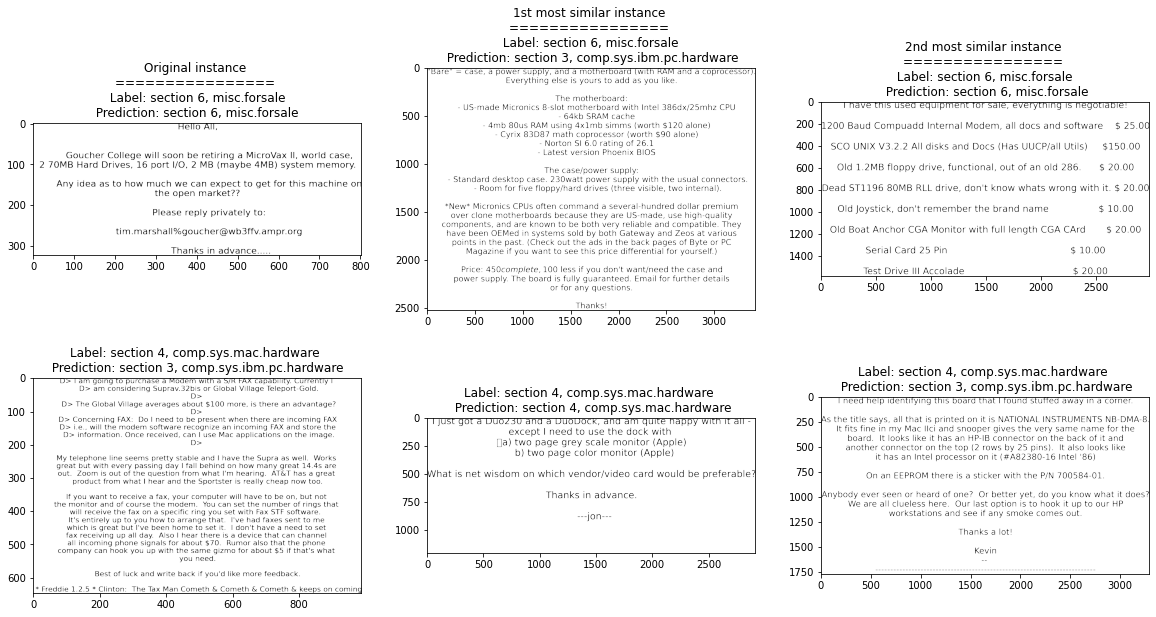

In [94]:
plot_similar(ds)

## Most similar labels distributions 

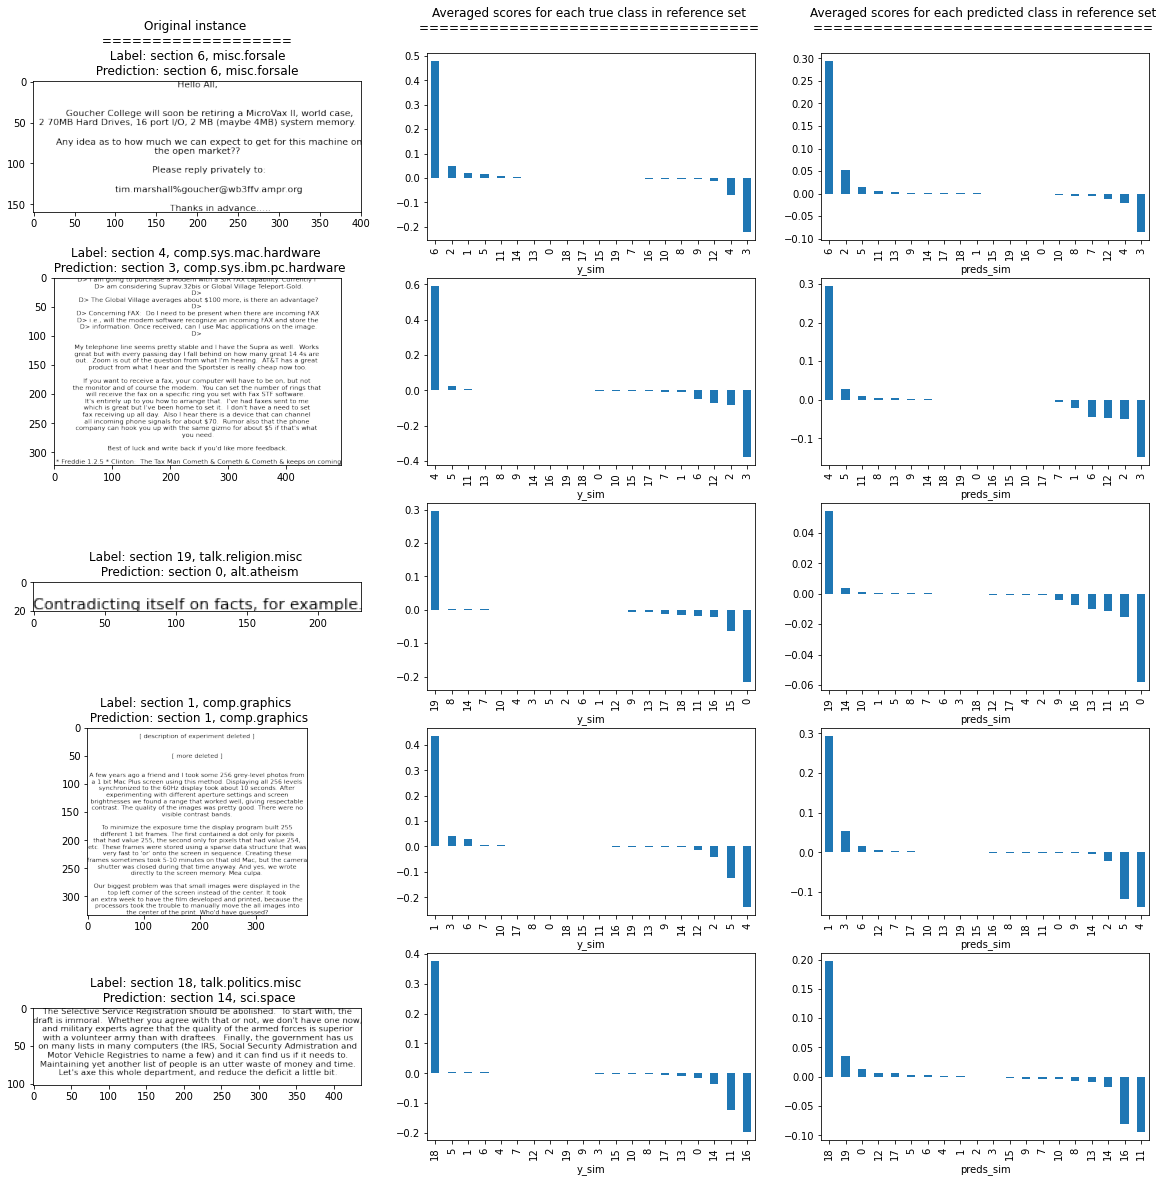

In [95]:
plot_distributions(ds)

In [85]:
ds[1]['x']

"D> I am going to purchase a Modem with a S/R FAX capability. Currently I \n D> am considering Suprav.32bis or Global Village Teleport-Gold.\n D>  \n D> The Global Village averages about $100 more, is there an advantage?\n D>  \n D> Concerning FAX:  Do I need to be present when there are incoming FAX \n D> i.e., will the modem software recognize an incoming FAX and store the \n D> information. Once received, can I use Mac applications on the image.\n D>  \n\nMy telephone line seems pretty stable and I have the Supra as well.  Works \ngreat but with every passing day I fall behind on how many great 14.4s are \nout.  Zoom is out of the question from what I'm hearing.  AT&T has a great \nproduct from what I hear and the Sportster is really cheap now too.\n\nIf you want to receive a fax, your computer will have to be on, but not \nthe monitor and of course the modem.  You can set the number of rings that \nwill receive the fax on a specific ring you set with Fax STF software.  \nIt's entir

In [86]:
ds[1]['x_sim'][0]

'I just got a Duo230 and a DuoDock, and am quite happy with it all -\nexcept I need to use the dock with \n\ta) two page grey scale monitor (Apple)\n  b) two page color monitor (Apple)\n\nWhat is net wisdom on which vendor/video card would be preferable?\n\nThanks in advance.\n\n  ---jon---\n\n\n'

-----------